## TF tensor input model flavors with MLflow Generic Model

In [21]:
import numpy as np
import tensorflow as tf
import mlflow
import time
import json
from mlflow.models import infer_signature
print("TF Version :", tf.__version__)

TF Version : 2.19.0


In [22]:
mlflow_uri = "http://mlflow-server:8888"
mlflow.set_tracking_uri(mlflow_uri)
time.sleep(5)
#mlflow.set_experiment(mlflow_uri)
mlflow.set_experiment("test_new")

<Experiment: artifact_location='mlflow-artifacts:/534639398483998411', creation_time=1746780148819, experiment_id='534639398483998411', last_update_time=1746780148819, lifecycle_stage='active', name='test_new', tags={}>

In [23]:
mnist = tf.keras.datasets.mnist

(x_train, y_train) , (x_test,y_test) = mnist.load_data()
x_train,x_test =  x_train/255.0 , x_test/255.0

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


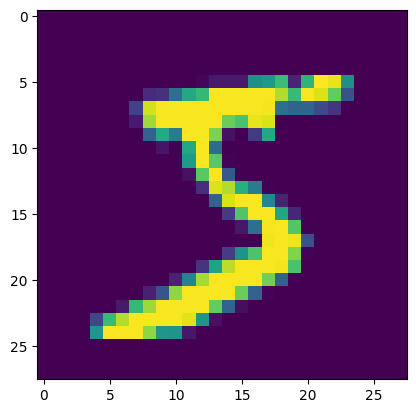

In [24]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])

In [25]:
import json
class custom_tf_model(mlflow.pyfunc.PythonModel):
    def __init__(self,params):
        self.params = params
        self.tf_model = None
        self.config = None

    def load_context(self, context = None, config_path = None):
        if context:
            config_path = context.artifacts["config_path"]
            
        else:
            pass
        self.config = json.load(open(config_path))

    
    def fit(self,x_train,y_train):
        tf_model,eval_loss,eval_acc = self.train_model()
        self.tf_model = tf_model

    def predict(self, context, model_input):
        return self.tf_model.predict(model_input)
    

    def train_model(self,p_epoch=2, p_optimizer = "Adam", l1_noNode= 32, l1_activation="relu",l1_dropout= 0.2):
        loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        model = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(l1_noNode,activation=l1_activation),
            tf.keras.layers.Dropout(l1_dropout),
            tf.keras.layers.Dense(10)
        ])

        model.compile(optimizer = p_optimizer,loss= loss_func, metrics = ['accuracy'])

        model.fit(x_train,y_train,epochs = p_epoch)

        eval_loss, eval_acc = model.evaluate(x_test,y_test,verbose=2)


        print(f"eval_loss : {eval_loss} | eval_acc : {eval_acc}")

        return model,eval_loss,eval_acc
        




/usr/local/lib/python3.12/site-packages/mlflow/pyfunc/utils/data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [26]:
config_path = "data_tf.json"
params_ = {
    "epochs" : 5
}
custom_tf_obj = custom_tf_model(params_)
custom_tf_obj.load_context(config_path=config_path)
custom_tf_obj.fit(x_train=x_train,y_train=y_train)

/usr/local/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 664us/step - accuracy: 0.7877 - loss: 0.7045
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 557us/step - accuracy: 0.9149 - loss: 0.2870
313/313 - 0s - 657us/step - accuracy: 0.9501 - loss: 0.1733
eval_loss : 0.173267662525177 | eval_acc : 0.9501000046730042


In [27]:
from sys import version_info
conda_env_tf = {
    "channels": ["defaults"],
    "dependencies": [
        f"python={version_info.major}.{version_info.minor}.{version_info.micro}",
        "pip",
        {"pip": ["mlflow",
                 f"tensorflow=={tf.__version__}"]
        },
    ],
    "name": "tf_env"
}
conda_env_tf

{'channels': ['defaults'],
 'dependencies': ['python=3.12.10',
  'pip',
  {'pip': ['mlflow', 'tensorflow==2.19.0']}],
 'name': 'tf_env'}

In [28]:
predictions_tf = custom_tf_obj.predict(context=None,model_input=x_test)
print(predictions_tf.shape)
model_signature = infer_signature(x_test,predictions_tf)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
(10000, 10)


In [29]:
type(model_signature)
model_signature

inputs: 
  [Tensor('float64', (-1, 28, 28))]
outputs: 
  [Tensor('float32', (-1, 10))]
params: 
  None

In [30]:
artifacts_tf = {
    "config_path" : config_path
}
artifacts_tf

{'config_path': 'data_tf.json'}

In [33]:
conda_env_tf

{'channels': ['defaults'],
 'dependencies': ['python=3.12.10',
  'pip',
  {'pip': ['mlflow', 'tensorflow==2.19.0']}],
 'name': 'tf_env'}

In [34]:
with mlflow.start_run(run_name="generic_model3") as run2:
    mlflow.pyfunc.log_model(
        "custom_tf",
        python_model = custom_tf_obj,
        artifacts = artifacts_tf,
        conda_env = conda_env_tf,
        signature = model_signature,
        input_example = x_train[0:5]
    )

2025/05/09 08:51:06 INFO mlflow.pyfunc: Validating input example against model signature
/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
🏃 View run generic_model3 at: http://mlflow-server:8888/#/experiments/534639398483998411/runs/28f033f60a804e3cbc523a7bd866f343
🧪 View experiment at: http://mlflow-server:8888/#/experiments/534639398483998411


In [35]:
import mlflow
logged_model = 'runs:/28f033f60a804e3cbc523a7bd866f343/custom_tf'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)



In [36]:
# Predict on a Pandas DataFrame.
import pandas as pd
result = loaded_model.predict(x_test[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [ ]:
result

array([[ -4.3955035 ,  -7.048949  ,   0.25928006,   0.43022665,
         -7.7559733 ,  -2.5771341 , -14.130099  ,   9.346293  ,
         -5.5107727 ,  -0.8487907 ],
       [  2.074889  ,  -3.155909  ,   8.88274   ,   2.727293  ,
        -12.673247  ,   0.82838815,  -0.21737751,  -9.107767  ,
          0.5520878 , -12.104176  ],
       [ -5.991908  ,   5.7187624 ,  -0.8011816 ,  -1.2026262 ,
         -1.7980468 ,  -4.308145  ,  -1.9653444 ,  -0.13185197,
         -0.27181995,  -3.6030943 ],
       [  9.958446  , -10.82613   ,  -0.9504436 ,  -4.1992207 ,
         -4.5619397 ,   1.1869639 ,   0.26589063,  -1.3704677 ,
         -4.014759  ,  -0.9070923 ],
       [ -2.219114  ,  -5.8248463 ,  -1.2631512 ,  -5.026081  ,
          5.5486293 ,  -1.059973  ,  -2.0788345 ,  -1.4808847 ,
         -3.132942  ,   2.6529171 ],
       [ -7.502462  ,   6.8547797 ,  -1.5869693 ,  -0.949343  ,
         -2.3948193 ,  -6.445119  ,  -4.0327444 ,   0.40362304,
          0.06977158,  -3.437453  ],
       [ -

: 